# **TD Détection des bosons de Higgs**


## I- Préparation des données (Pre-processing)

### 1- Importation des bibliothèques

In [22]:
import numpy as np
import pandas as pd
import csv
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 2- Lecture des fichiers CSV
Jeu de données disponible dans http://opendata.cern.ch/record/328

**Ce jeu de données est très grand, vous povez sélectionner un sous-échantillon pour travailler avec**.

In [23]:

dataFilename = 'atlas-higgs.csv'
data = pd.read_csv(dataFilename)
print(data.shape)
print(data.dtypes)
data.head()

(818238, 35)
EventId                          int64
DER_mass_MMC                   float64
DER_mass_transverse_met_lep    float64
DER_mass_vis                   float64
DER_pt_h                       float64
DER_deltaeta_jet_jet           float64
DER_mass_jet_jet               float64
DER_prodeta_jet_jet            float64
DER_deltar_tau_lep             float64
DER_pt_tot                     float64
DER_sum_pt                     float64
DER_pt_ratio_lep_tau           float64
DER_met_phi_centrality         float64
DER_lep_eta_centrality         float64
PRI_tau_pt                     float64
PRI_tau_eta                    float64
PRI_tau_phi                    float64
PRI_lep_pt                     float64
PRI_lep_eta                    float64
PRI_lep_phi                    float64
PRI_met                        float64
PRI_met_phi                    float64
PRI_met_sumet                  float64
PRI_jet_num                      int64
PRI_jet_leading_pt             float64
PRI_jet_lead

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


### 3- Supprimer les colonnes superflues
Utiliser la fonction del pour supprimer les colonnes 'EventId','Weight', 'KaggleSet', 'KaggleWeight'.
Transformer ensuite la colonne 'label' en valeurs binaires 0/1.

In [24]:
del(data['EventId'])
del(data['Weight'])
del(data['KaggleSet'])
del(data['KaggleWeight'])
data['Label'] = data['Label'].map({'s': 1, 'b': 0})
#.............

### 4- Traiter les données manquantes
Les données manquantes dans ce fichier sont désignées par -999. Pour les remplacer, il faudra utiliser la classe `SimpleImputer`.

In [25]:
#TRaitement des données manquantes désignes par -999
# Store column names before imputation
column_names = data.columns

imputer = SimpleImputer(missing_values=-999, strategy='mean')
data_imputed = imputer.fit_transform(data)

# Convert back to DataFrame with original column names
data = pd.DataFrame(data_imputed, columns=column_names)


### Données aberrantes
Vérifier si le jeu de données contient des données aberrantes en affichant les boxplot de toutes les colonnes.

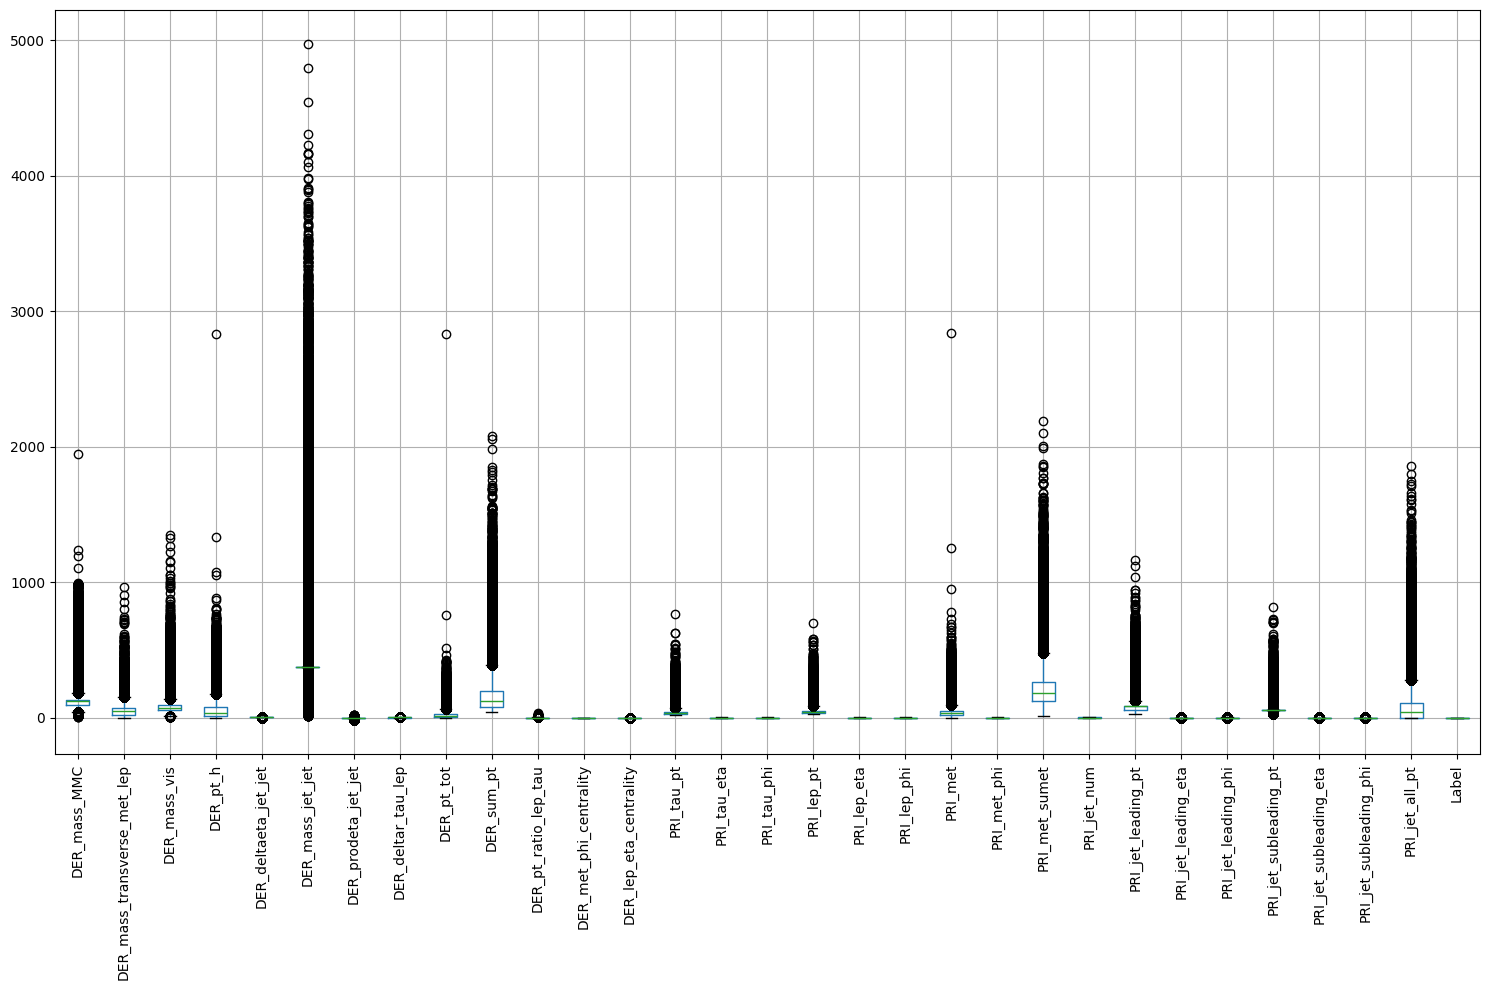

In [26]:
#affichage des boxplot des différents attributs

data.boxplot(figsize=(15, 10))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 5-  Calibration des données avec *MinMaxScaler* de Sci-kit Learn
Mettre à l'échelle toutes les colonnes avec le 'MinMaxScaler"

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)


Croisement de certaines paires de colonnes

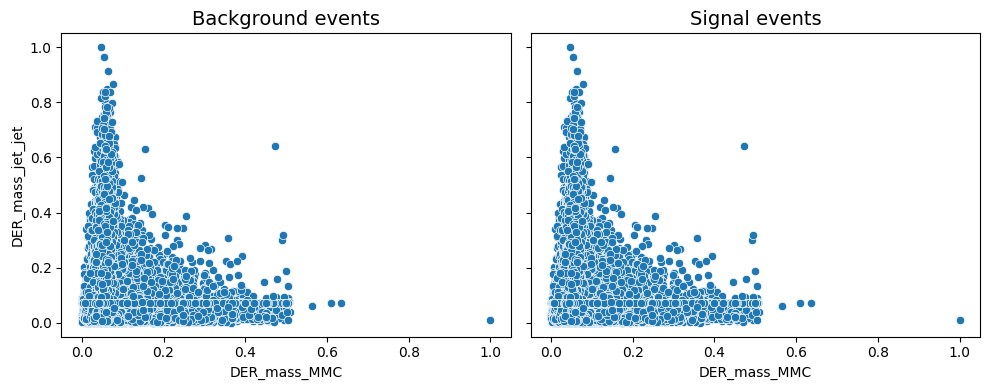

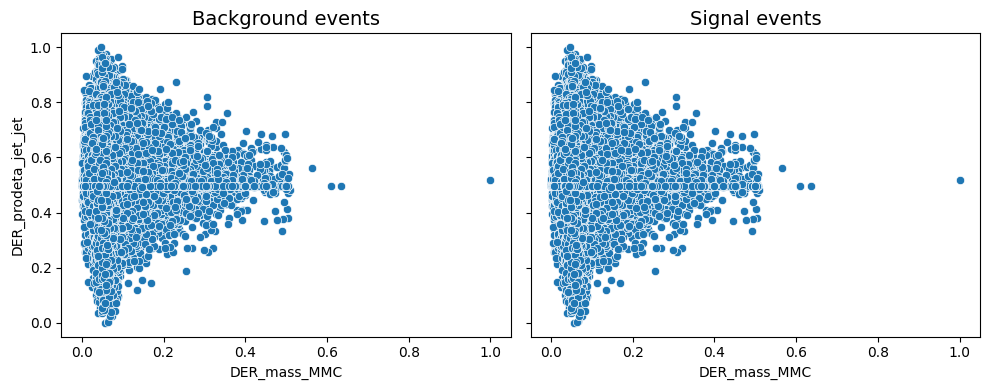

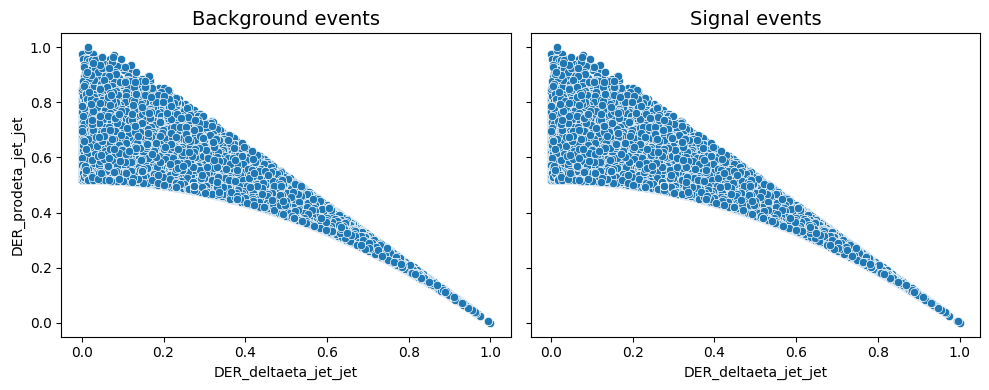

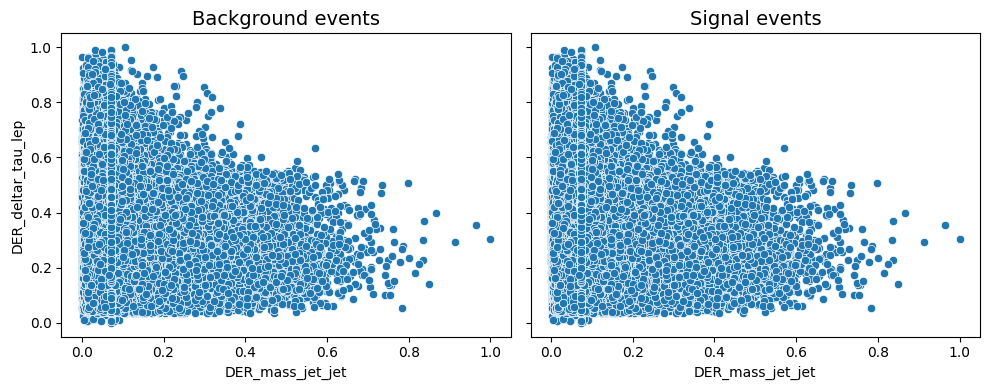

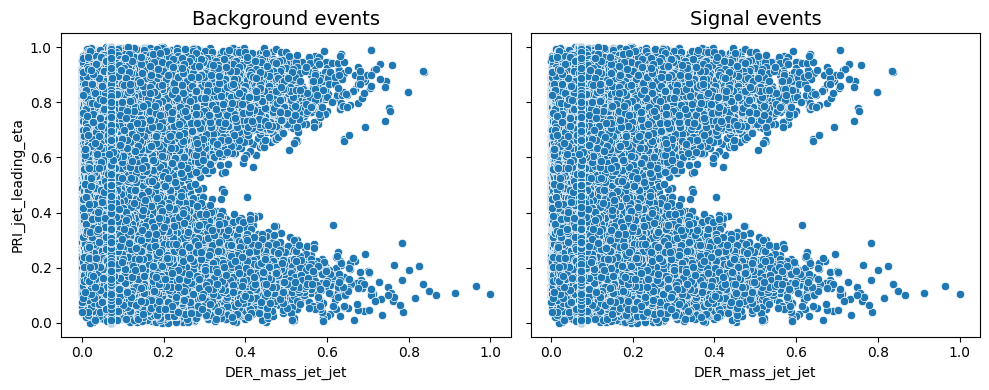

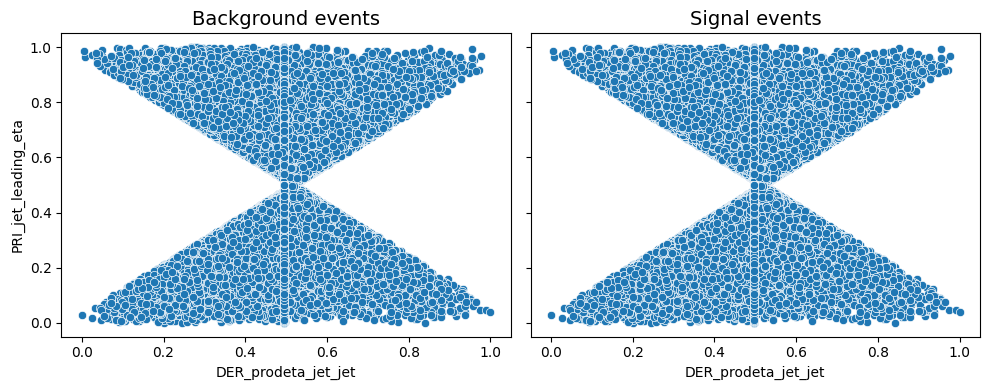

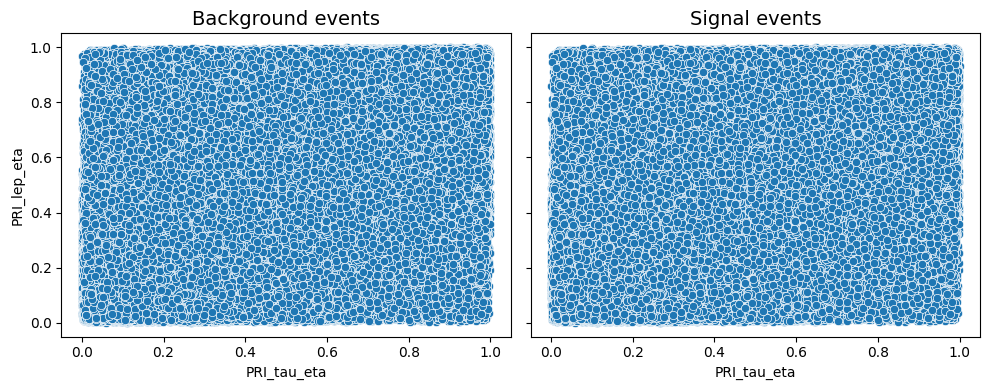

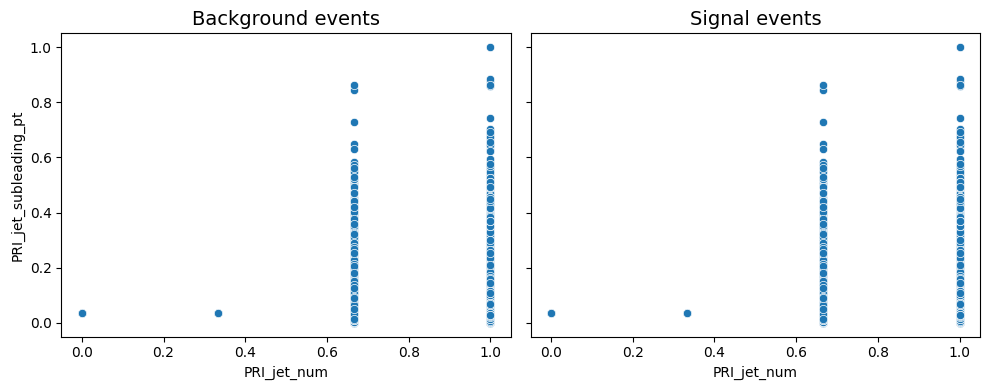

In [28]:

pairs_selected = [
    ('DER_mass_MMC', 'DER_mass_jet_jet'),
    ('DER_mass_MMC', 'DER_prodeta_jet_jet'),
    ('DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'),
    ('DER_mass_jet_jet', 'DER_deltar_tau_lep'),
    ('DER_mass_jet_jet', 'PRI_jet_leading_eta'),
    ('DER_prodeta_jet_jet', 'PRI_jet_leading_eta'),
    ('PRI_tau_eta', 'PRI_lep_eta'),
    ('PRI_jet_num', 'PRI_jet_subleading_pt')
]
for z in pairs_selected:
    fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharex = True, sharey = True)
    sns.scatterplot(data = data_scaled, x = z[0], y = z[1], ax = ax[0])
    sns.scatterplot(data = data_scaled, x = z[0], y = z[1], ax = ax[1])
    ax[0].set_title("Background events", fontsize = 14)
    ax[1].set_title("Signal events", fontsize = 14)
    plt.tight_layout()

plt.show()

## Unbalance Ratio
Afficher l'histogramme de la colonne target pour vérifier l'existence d'un déséquiibre entre la classe positive et la classe négative.

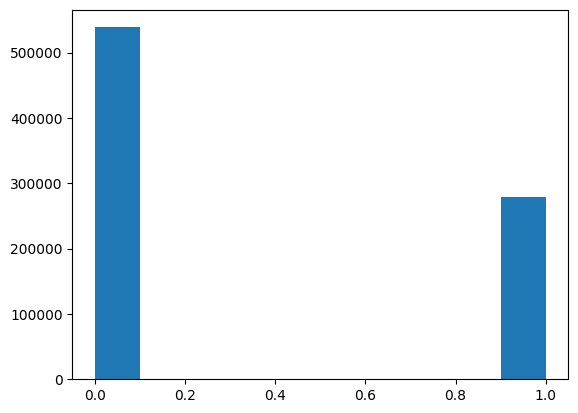

In [29]:

plt.hist(data_scaled['Label'])
plt.show()


### 6- Découpage en Train and test
Séparer les données *input* du *target* et découper le jeu de données en train et test (30% pour le test)

In [30]:
#détacher l'output

#subdivision des données éch.test = 30%
x_train, x_test, y_train, y_test = model_selection.train_test_split(data_scaled.drop('Label', axis=1), data_scaled['Label'], test_size=0.3, random_state=42)


print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)


(572766, 30) (245472, 30) (572766,) (245472,)


Création de liste des mesures de performances pour la comparaison de modèles

In [31]:
#for saving results
list_accuracies=[]
list_F1=[]
list_times=[]

# II- Learning I: Models Only (No additional Paradigms)

## 1- Decision Tree

A decision tree is a supervised machine learning algorithm used for both classification and regression tasks.
It works by creating a tree-like model of decisions based on features in the data.

 Key characteristics of decision trees:
 1. Non-linear: Can capture complex relationships in data
 2. Interpretable: Easy to understand and visualize
 3. Hierarchical: Makes decisions in a top-down approach
 4. Prone to overfitting: Can be mitigated by pruning or limiting tree depth
 5. Handles both numerical and categorical data

 How it works:
 1. The algorithm starts at the root of the tree with the entire dataset.
 2. It selects the best feature to split the data based on a criterion (e.g., Gini impurity or information gain).
 3. The data is split into subsets based on the selected feature's values.
 4. This process is repeated recursively for each subset, creating new nodes in the tree.
 5. The process stops when a stopping criterion is met (e.g., max depth, min samples per leaf, or pure subset).
 6. The final nodes (leaves) represent the predicted class or value.

 In our case, we're using it for classification with a max_depth of 3 to prevent overfitting.



temp 2.963106155395508
accuray :  0.7956956394211967
F1 Score :  0.6783315908639014


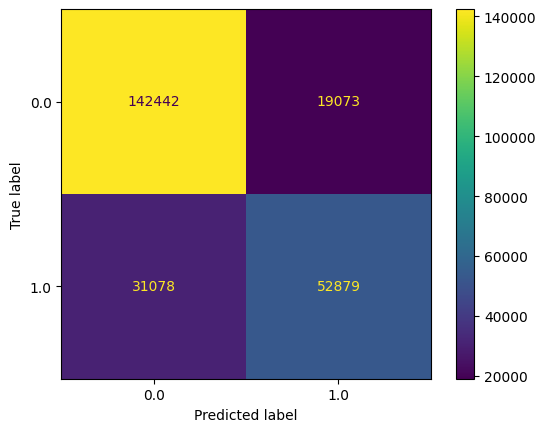

In [32]:
from sklearn.tree import DecisionTreeClassifier
#création d'une instance d'un classieur DecisionTree
dt_class= DecisionTreeClassifier(max_depth=3)
deb = time.time()
#Si le training échoue, il faut relancer le code
dt_class.fit(x_train, y_train)
fin=time.time()
res_dt = dt_class.predict(x_test)
print("temp",(fin-deb))
list_times.append(fin-deb)
acc=accuracy_score(res_dt,y_test)
F1=f1_score(res_dt,y_test)
print("accuray : ",acc)
print("F1 Score : ", F1)
list_accuracies.append(acc)
list_F1.append(F1)

classes=['Signal','Background']
cm = confusion_matrix(y_test, res_dt, labels=dt_class.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt_class.classes_)
disp.plot()
plt.show()

## 2- Logistic Regression

Logistic Regression is a statistical method used for binary classification problems. Despite its name, it's used for classification rather than regression tasks. Here's an overview of how it works:

1. Linear combination: It creates a linear combination of input features.
2. Sigmoid function: The linear combination is passed through a sigmoid function to produce a probability between 0 and 1.
3. Decision boundary: A threshold (usually 0.5) is used to classify the output probability into one of two classes.
4. Optimization: The model parameters are optimized using techniques like maximum likelihood estimation or gradient descent.

 Key characteristics:
1. Interpretable: The coefficients can be interpreted as the importance of each feature.
2. Efficient: Works well for linearly separable classes and with large datasets.
3. Probabilistic output: Provides probability estimates for predictions.
4. Assumes linearity: May not perform well with highly non-linear relationships.

In our case, we're using the 'sag' solver, which is suitable for large datasets and uses a stochastic average gradient descent method for optimization.



temp 4.787308931350708
accuray :  0.7501466562377787
F1 Score :  0.5913052749420262


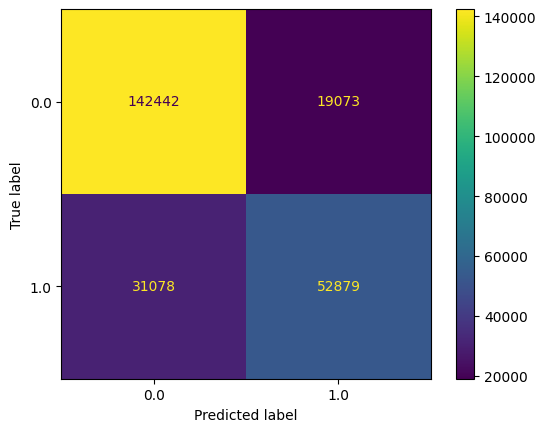

In [33]:
from sklearn.linear_model import LogisticRegression
lg_clf = LogisticRegression(solver='sag')
#Le solveur par défaut pour logistic regression est , "liblinear" adapté pour les problèmes de petite et moyenne taille
#sag" : est un solveur basé sur l'optimisation stochastique (méthode de gradient moyen stochastique).
#Il est adaptée aux problèmes de grande taille.
deb = time.time()
lg_clf.fit(x_train, y_train)
fin=time.time()
res_lg = lg_clf.predict(x_test)
print("temp",(fin-deb))
list_times.append(fin-deb)
acc=accuracy_score(res_lg,y_test)
F1=f1_score(res_lg,y_test)
print("accuray : ",acc)
print("F1 Score : ", F1)
list_accuracies.append(acc)
list_F1.append(F1)

classes=['Signal','Background']
cm = confusion_matrix(y_test, res_dt, labels=dt_class.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt_class.classes_)
disp.plot()
plt.show()

##  3- Baysien

Bayesian models are probabilistic models based on Bayes' theorem. They work by updating prior beliefs about parameters or hypotheses using observed data to form posterior probabilities. In machine learning, Naive Bayes is a popular Bayesian model.

Naive Bayes classifiers work as follows:
1. They assume features are independent given the class (the "naive" assumption).
2. They use Bayes' theorem to calculate the probability of each class given the input features.
3. They select the class with the highest probability as the prediction.

Key characteristics of Bayesian models:
1. Probabilistic: They provide probability estimates for predictions.
2. Incorporate prior knowledge: Can use prior probabilities in the model.
3. Handle uncertainty: Can work well with limited or noisy data.
4. Efficient: Often fast to train and make predictions, especially Naive Bayes.

In our case, we're using Gaussian Naive Bayes, which assumes the features follow a Gaussian distribution within each class.


temp 0.10767102241516113
accuray :  0.6893535718941468
F1 Score :  0.49267841579679195


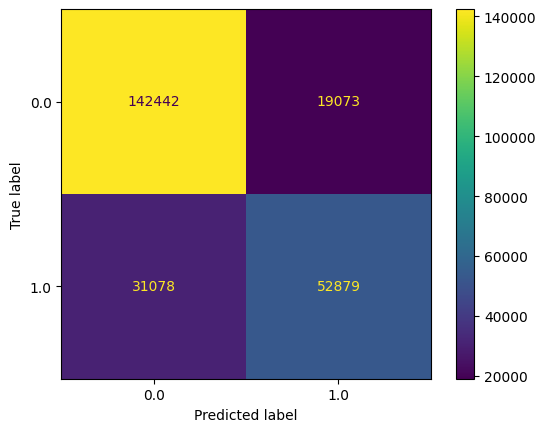

In [34]:
from sklearn.naive_bayes import GaussianNB
gn_clf=GaussianNB()
deb = time.time()
gn_clf.fit(x_train, y_train)
fin=time.time()
res_gn = gn_clf.predict(x_test)
print("temp",(fin-deb))
list_times.append(fin-deb)
acc=accuracy_score(res_gn,y_test)
F1=f1_score(res_gn,y_test)
print("accuray : ",acc)
print("F1 Score : ", F1)
list_accuracies.append(acc)
list_F1.append(F1)

classes=['Signal','Background']
cm = confusion_matrix(y_test, res_dt, labels=dt_class.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt_class.classes_)
disp.plot()
plt.show()


### Plotting results

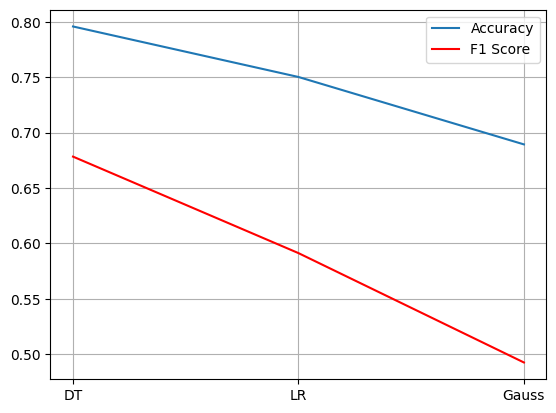

In [35]:
x = ['DT', 'LR', 'Gauss']
plt.grid()
plt.plot(x,list_accuracies)
plt.plot(x,list_F1,'r')
plt.legend(['Accuracy', 'F1 Score'])
plt.show()

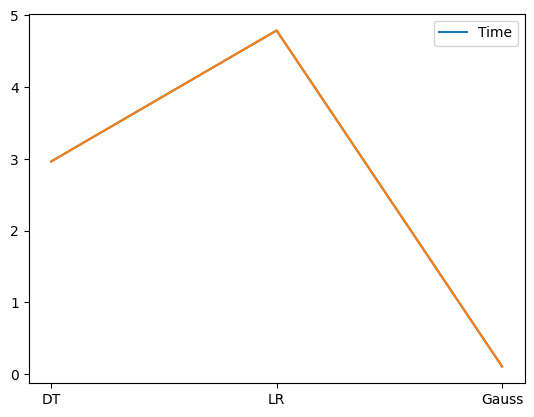

In [38]:
#figures des temps de calcul
plt.grid()
plt.plot(x,list_times)
plt.legend(['Time'])
plt.show()

# II- Learning II: Ensemble Learning

## II-1 Bagging

Bagging (Bootstrap Aggregating)

Bagging is an ensemble learning technique that combines multiple models to improve prediction accuracy and reduce overfitting.

How it works:
1. Create multiple subsets of the original dataset using bootstrap sampling (random sampling with replacement)
2. Train a separate model on each subset
3. Combine predictions from all models:
   - For classification: use majority voting
   - For regression: use averaging

Advantages of Bagging:
- Reduces overfitting
- Improves stability and accuracy
- Works well with high-variance models (e.g., decision trees)

Common implementations:
- Random Forest: Bagging with decision trees and random feature selection
- Bagging Classifier/Regressor: Can use any base estimator (e.g., logistic regression, neural networks)



### Bagging with Random Forest
class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [37]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
deb = time.time()
....

SyntaxError: invalid syntax (604894781.py, line 3)

### Bagging classifier with Logistic Regression
class sklearn.ensemble.BaggingClassifier(estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0, base_estimator='deprecated')

In [ ]:
from sklearn.ensemble import BaggingClassifier
#max_samples: taille maximale de l'échantillon par rapport à l'échantillon initial
#max_features: nombre d'attributs à sélectionner d'une façon aléatoire
# max_features=1,random_state=0


### Bagging classifier with Baysian
class sklearn.ensemble.BaggingClassifier(estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0, base_estimator='deprecated')

In [ ]:
#max_samples: taille maximale de l'échantillon par rapport à l'échantillon initial
#max_features: nombre d'attributs à sélectionner d'une façon aléatoire
# max_features=1,random_state=0
#bagging = BaggingClassifier(GaussianNB(),n_estimators=50,max_samples=0.1,n_jobs=-1)
bagging = BaggingClassifier(GaussianNB(),n_estimators=50,max_samples=0.1)
deb = time.time()
bagging.fit(x_train, y_train)
fin=time.time()
list_times.append(fin-deb)
res_bag = bagging.predict(x_test)
print("temp RF ",(fin-deb))
acc=accuracy_score(res_bag,y_test)
F1=f1_score(res_bag,y_test)
print("accuray RF ", acc)
print("F1 Score : ", F1)
list_accuracies.append(acc)
list_F1.append(F1)
cm = confusion_matrix(y_test, res_bag, labels=rf_etc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_etc.classes_)
disp.plot()
plt.show()

### Plotting results

In [ ]:
x = ['DT', 'LR', 'Gauss', "RF", "Bag LR", "Bag Gauss"]
plt.grid()
#plt.plot(...)
#..........
plt.show()

In [ ]:
#figures des temps de calcul
plt.grid()
plt.plot(x,list_times)

#Exercice: #
Faites varier les valeurs du paramètre 'n_estimators' afin de visulaliser l'effet du nombre de modèles dans l'apprentissage d'ensemble sur la qualité du classifieur.


## II - 2- Boosting

### AdaBoost
lass sklearn.ensemble.AdaBoostClassifier(estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None, base_estimator='deprecated')

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
deb = time.time()
....

## Gradient Boost (Gradient Boosted Decision Trees)

This algorithm builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. Binary classification is a special case where only a single regression tree is induced.

class sklearn.ensemble.GradientBoostingClassifier(*, loss='log_loss', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0

In [ ]:

from sklearn.ensemble import GradientBoostingClassifier


In [ ]:
x = ['DT', 'LR', 'Gauss', "RF", "Bag LR", "Bag Gauss", "AdaBoost", "GdBoost" ]
plt.grid()
plt.plot(x,list_accuracies)
plt.plot(x,list_F1,'r')
plt.show()

# V- Learning IV : Unbalance Learning

### Les méthodes d'échantillonage (*sampling*) à tester:


*   Under Sampling (US)
*   Over  Samplig (OS)
*   SMOTE (synthetic sampling)
*   BSMOTE (Borderline Sampling)



In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
#Under Sampling
us = RandomUnderSampler(random_state=1)
x_us, y_us = us.fit_resample(x_train, y_train)
#Over Sampling

#SMOTE # lourd en exécution!!!!
sm = SMOTE(random_state=1)
...
#Borderline SMOTE  #lourd en excution !!!!
bl = BorderlineSMOTE(random_state=1)
....

## Decision Tree avec des **échantillons** balancés

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_class= DecisionTreeClassifier()
# test avec under/overSampling, SMOTE/BSMOTE sampling
deb = time.time()
#dt_class.fit(x_us, y_us) #under sample
dt_class.fit(x_os, y_os) #over sample
...
fin=time.time()
res_dt = dt_class.predict(x_test)
print("temp",(fin-deb))
acc=accuracy_score(res_dt,y_test)
F1=f1_score(res_dt,y_test)
print("accuray : ",acc)
print("F1 Score : ", F1)
list_accuracies.append(acc)
list_F1.append(F1)
classes=['Signal','Background']
cm = confusion_matrix(y_test, res_dt, labels=dt_class.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt_class.classes_)
disp.plot()
plt.show()

## Classification avec Baysian sur des données balancées

In [ ]:
from sklearn.naive_bayes import GaussianNB
gn_clf=GaussianNB()
deb = time.time()
gn_clf.fit(x_us, y_us) #under sample
......